In [1]:
from reader_utils.corpus_builder_utils import *
from note_utils.pitch_dictionary import PitchDictionary
from reader_utils.dataset_builder import DatasetBuilder
from model_utils.model_utils import *
from gensim.models import Word2Vec

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import random
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
pd = PitchDictionary("dataset_objects/pitches_dict.txt")
db = DatasetBuilder("dataset_objects/full_corpus")

In [3]:
raw_corpus_path = "dataset_objects/raw_full_corpus"
raw_corpus = db.read_corpus_from_path(raw_corpus_path)

In [4]:
model = Word2Vec(vector_size=50, window=5, min_count=1, negative=5, epochs=10)

In [5]:
model.build_vocab(raw_corpus)

In [6]:
model.train(raw_corpus, total_examples=model.corpus_count, epochs=10, report_delay=1)

(1962951, 8810820)

In [7]:
# most_similar(positive=["woman", "king"], negative=["man"]) => 
# (king – man) + woman = ?    =>    (king – man) = ? - woman
model.wv.most_similar(positive=["re5", "sol4"], negative=["la4"], topn=3)

[('es', 0.30354681611061096),
 ('do5', 0.2732149064540863),
 ('si4b1', 0.23979681730270386)]

In [8]:
X = [model.wv[x] for x in model.wv.index_to_key]

In [9]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

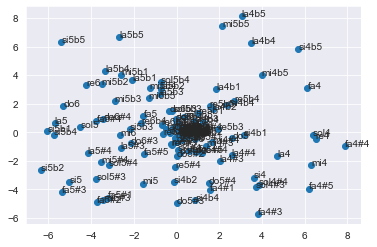

In [10]:
plt.scatter(result[:, 0], result[:, 1])
for i, pitch in enumerate(model.wv.index_to_key):
	plt.annotate(pitch, xy=(result[i, 0], result[i, 1]))

In [11]:
corpus_path_pc = "dataset_objects/raw_full_corpus_pitch_classes"
raw_corpus_pc = db.read_corpus_from_path(corpus_path_pc)

In [12]:
model_pc = Word2Vec(vector_size=20, window=10, min_count=100, negative=5, epochs=10)
model_pc.build_vocab(raw_corpus_pc)

In [13]:
model_pc.train(raw_corpus_pc, total_examples=model_pc.corpus_count, epochs=10, report_delay=1)

(1536375, 8810820)

In [14]:
# most_similar(positive=["woman", "king"], negative=["man"]) => 
# (king – man) + woman = ?    =>    (king – man) = ? - woman
model_pc.wv.most_similar(positive=["re", "sol"], negative=["la"], topn=3)

[('mib2', 0.19575639069080353),
 ('solb4', 0.1369364708662033),
 ('re#4', 0.12234822660684586)]

In [15]:
num_dimensions = 2  # final num dimensions (2D, 3D, etc)

# extract the words & their vectors, as numpy arrays
vectors = np.asarray(model_pc.wv.vectors)
labels = np.asarray(model_pc.wv.index_to_key)  # fixed-width numpy strings

# reduce using t-SNE
tsne = TSNE(n_components=num_dimensions, random_state=0)
vectors = tsne.fit_transform(vectors)

x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]

/Users/ihp/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ihp/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


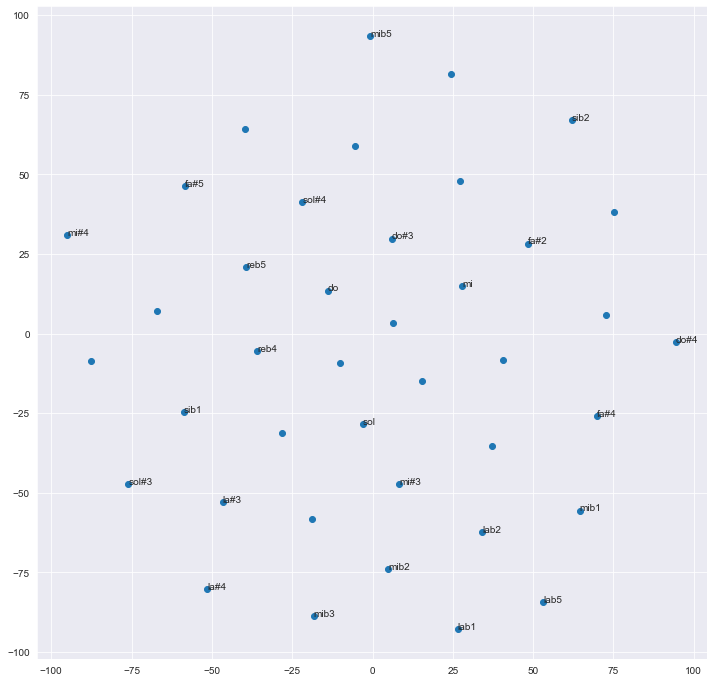

In [16]:
random.seed(0)

plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals)

#
# Label randomly subsampled 25 data points
#
indices = list(range(len(labels)))
selected_indices = random.sample(indices, 25)
for i in selected_indices:
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))
